In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")

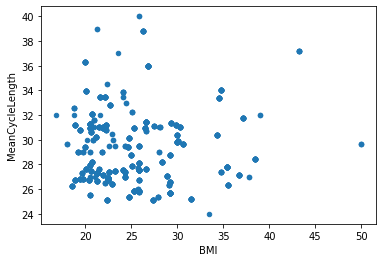

In [12]:
cycle_data = pd.read_csv('FedCycleData071012 (2).csv')

# clean mean cycle length
# change type of column to int
replace_str = cycle_data.at[1,'MeanCycleLength']
cycle_data['MeanCycleLength'].replace(replace_str,np.nan,inplace=True)
cycle_data['MeanCycleLength'] = cycle_data['MeanCycleLength'].astype(float)
# downfill mean cycle length
cycle_data['MeanCycleLength'] = cycle_data.groupby('ClientID')['MeanCycleLength'].ffill()

# clean age
replace_str = cycle_data.at[1,'Age']
cycle_data['Age'].replace(replace_str,np.nan,inplace=True)
cycle_data['Age'] = cycle_data['Age'].astype(float)
# downfill mean cycle length
cycle_data['Age'] = cycle_data.groupby('ClientID')['Age'].ffill()

# clean BMI
replace_str = cycle_data.at[1,'BMI']
cycle_data['BMI'].replace(replace_str,np.nan,inplace=True)
cycle_data['BMI'] = cycle_data['BMI'].astype(float)
# downfill mean cycle length
cycle_data['BMI'] = cycle_data.groupby('ClientID')['BMI'].ffill()
cycle_data.plot.scatter('BMI','MeanCycleLength')

# clean Mean Menses Length
replace_str = cycle_data.at[1,'MeanMensesLength']
cycle_data['MeanMensesLength'].replace(replace_str,np.nan,inplace=True)
cycle_data['MeanMensesLength'] = cycle_data['MeanMensesLength'].astype(float)
# downfill mean cycle length
cycle_data['MeanMensesLength'] = cycle_data.groupby('ClientID')['MeanMensesLength'].ffill()

# clean menses scores (if it is missing it should be a zero)
menses_scores = ['MensesScoreDayOne', 'MensesScoreDayTwo',
       'MensesScoreDayThree', 'MensesScoreDayFour', 'MensesScoreDayFive',
       'MensesScoreDaySix', 'MensesScoreDaySeven', 'MensesScoreDayEight',
       'MensesScoreDayNine', 'MensesScoreDayTen', 'MensesScoreDay11',
       'MensesScoreDay12', 'MensesScoreDay13', 'MensesScoreDay14',
       'MensesScoreDay15']
for menses_day in menses_scores:
    cycle_data[menses_day].replace(' ',0,inplace=True)
    cycle_data[menses_day] = cycle_data[menses_day].astype(float)
    
# drop data points that are missing menstrual cycle
cycle_data = cycle_data.drop(index=[1107,1298,1340,1664])
cycle_data['LengthofMenses'] = cycle_data['LengthofMenses'].astype(float)

# drop missing BMI
cycle_data.dropna(subset=['BMI'],inplace=True)

## fill empty `EstimatedDayOfOvulation` with mean for that individual
replace_str = ' '
cycle_data['EstimatedDayofOvulation'].replace(replace_str,np.nan,inplace=True)
cycle_data['EstimatedDayofOvulation'].replace([np.inf, -np.inf], np.nan, inplace=True)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].astype(float)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].fillna(cycle_data.groupby('ClientID')['EstimatedDayofOvulation'].transform('mean'))

# if there are extra NaNs, replace those with the mean for the dataset
cycle_data['EstimatedDayofOvulation'].fillna(cycle_data['EstimatedDayofOvulation'].mean(),inplace=True)
cycle_data['EstimatedDayofOvulation'] = cycle_data['EstimatedDayofOvulation'].round(0).astype(int)

## fill `LengthofLutealPhase` with difference between LengthofCycle and EstimatedDayofOvulation for that individual
cycle_data['LengthofLutealPhase'] = cycle_data['LengthofCycle'] - cycle_data['EstimatedDayofOvulation']

## fill empty `FirstDayofHigh` with mean for that individual
replace_str = ' '
cycle_data['FirstDayofHigh'].replace(replace_str,np.nan,inplace=True)
cycle_data['FirstDayofHigh'].replace([np.inf, -np.inf], np.nan, inplace=True)
cycle_data['FirstDayofHigh'] = cycle_data['FirstDayofHigh'].astype(float)
cycle_data['FirstDayofHigh'] = cycle_data['FirstDayofHigh'].fillna(cycle_data.groupby('ClientID')['EstimatedDayofOvulation'].transform('mean'))

# if there are extra NaNs, replace those with the mean for the dataset
cycle_data['FirstDayofHigh'].fillna(cycle_data['FirstDayofHigh'].mean(),inplace=True)
cycle_data['FirstDayofHigh'] = cycle_data['FirstDayofHigh'].round(0).astype(int)

In [13]:
# feature engineering
# create bmi category column
def bmi_category(row):
    if row['BMI'] < 18.5:
        return '16-18.5'
    elif row['BMI'] < 25 and row['BMI'] >= 18.5:
        return '18.5-25'
    elif row['BMI'] < 30 and row['BMI'] >= 25:
        return '25-30'
    elif row['BMI'] < 35 and row['BMI'] >= 30:
        return '30-35'
    else:
        return '35-50'

cycle_data['BMICat'] = cycle_data.apply(bmi_category, axis=1)

# create age_category column
def age_category(row):
    # these are each of the quartiles for ages
    if row['Age'] < 28:
        return '21-28'
    elif row['Age'] < 32 and row['Age'] >= 28:
        return '28-32'
    elif row['Age'] < 36 and row['Age'] >= 32:
        return '32-36'
    elif row['Age'] < 42 and row['Age'] >= 36:
        return '36-42'

cycle_data['AgeCat'] = cycle_data.apply(age_category, axis=1)

In [14]:
# set up for analysis
# features to use for analysis
clean = cycle_data[['LengthofCycle','MeanCycleLength','EstimatedDayofOvulation','LengthofLutealPhase','FirstDayofHigh', 'LengthofMenses',
       'MeanMensesLength', 'MensesScoreDayOne', 'MensesScoreDayTwo',
       'MensesScoreDayThree', 'MensesScoreDayFour', 'MensesScoreDayFive',
       'MensesScoreDaySix', 'MensesScoreDaySeven', 'MensesScoreDayEight',
       'MensesScoreDayNine', 'MensesScoreDayTen', 'MensesScoreDay11',
       'MensesScoreDay12', 'MensesScoreDay13', 'MensesScoreDay14',
       'MensesScoreDay15','BMICat','AgeCat']]
# for now just drop na values
clean = clean.dropna()
X = clean[['LengthofCycle','MeanCycleLength','EstimatedDayofOvulation','LengthofLutealPhase','FirstDayofHigh', 'LengthofMenses',
       'MeanMensesLength', 'MensesScoreDayOne', 'MensesScoreDayTwo',
       'MensesScoreDayThree', 'MensesScoreDayFour', 'MensesScoreDayFive',
       'MensesScoreDaySix', 'MensesScoreDaySeven', 'MensesScoreDayEight',
       'MensesScoreDayNine', 'MensesScoreDayTen', 'MensesScoreDay11',
       'MensesScoreDay12', 'MensesScoreDay13', 'MensesScoreDay14',
       'MensesScoreDay15']]

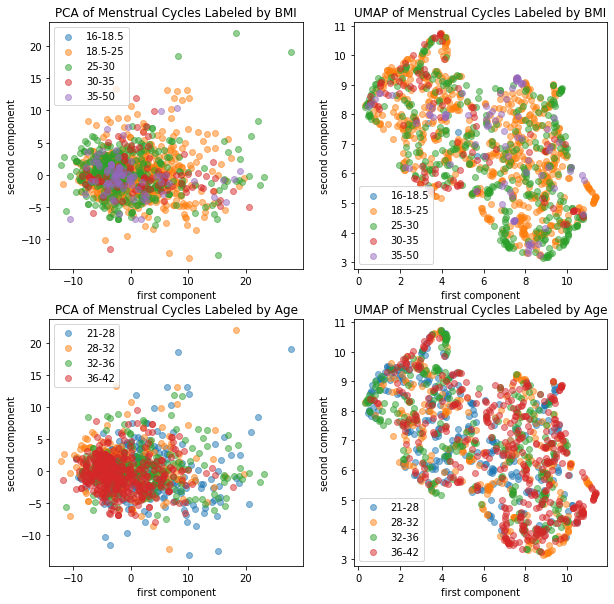

In [15]:
# center the data
X_center = X - np.mean(X,axis=0)

y = clean['BMICat']
labels = ['16-18.5','18.5-25','25-30','30-35','35-50']
pca = PCA(n_components=2)
pca.fit(X_center)
X_PCA = pca.transform(X_center)

plt.figure(figsize=(10,10))
plt.subplot(221)
for label in labels:
    mask = np.where(y==label)
    # plot
    plt.scatter(X_PCA[mask,0],X_PCA[mask,1],label=label,alpha=.5)

plt.xlabel('first component')
plt.ylabel('second component')
plt.legend()
plt.title('PCA of Menstrual Cycles Labeled by BMI')

# umap
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)

plt.subplot(222)
for label in labels:
    mask = np.where(y==label)
    # plot
    plt.scatter(X_umap[mask,0],X_umap[mask,1],label=label,alpha=.5)

plt.xlabel('first component')
plt.ylabel('second component')
plt.legend()
plt.title('UMAP of Menstrual Cycles Labeled by BMI')

y = clean['AgeCat']
labels = ['21-28','28-32','32-36','36-42']

plt.subplot(223)
for label in labels:
    mask = np.where(y==label)
    # plot
    plt.scatter(X_PCA[mask,0],X_PCA[mask,1],label=label,alpha=.5)

plt.xlabel('first component')
plt.ylabel('second component')
plt.legend()
plt.title('PCA of Menstrual Cycles Labeled by Age')

plt.subplot(224)
for label in labels:
    mask = np.where(y==label)
    # plot
    plt.scatter(X_umap[mask,0],X_umap[mask,1],label=label,alpha=.5)

plt.xlabel('first component')
plt.ylabel('second component')
plt.legend()
plt.title('UMAP of Menstrual Cycles Labeled by Age')
plt.savefig('pca_umap')
plt.show()

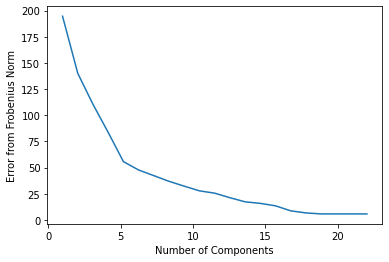

In [25]:
features = ['LengthofCycle','MeanCycleLength','EstimatedDayofOvulation','LengthofLutealPhase','FirstDayofHigh', 'LengthofMenses',
       'MeanMensesLength', 'MensesScoreDayOne', 'MensesScoreDayTwo',
       'MensesScoreDayThree', 'MensesScoreDayFour', 'MensesScoreDayFive',
       'MensesScoreDaySix', 'MensesScoreDaySeven', 'MensesScoreDayEight',
       'MensesScoreDayNine', 'MensesScoreDayTen', 'MensesScoreDay11',
       'MensesScoreDay12', 'MensesScoreDay13', 'MensesScoreDay14',
       'MensesScoreDay15']
error = []

for k in range(1,len(features)):
    # fit model
    model = NMF(n_components=k)
    W = model.fit_transform(X)
    H = model.components_
    error.append(np.linalg.norm(X-W@H,ord='fro'))
x_plot = np.linspace(1,len(features),len(features)-1)
plt.plot(x_plot,error)
plt.xlabel('Number of Components')
plt.ylabel('Error from Frobenius Norm')
plt.show()

[[1.06 0.32 0.01 ... 0.   0.   0.  ]
 [1.03 0.29 0.11 ... 0.   0.   0.  ]
 [1.06 0.17 0.31 ... 0.   0.   0.  ]
 ...
 [0.99 0.01 0.   ... 0.   0.   0.  ]
 [0.76 0.   0.4  ... 0.   0.   0.  ]
 [1.01 0.01 0.17 ... 0.   0.   0.  ]]


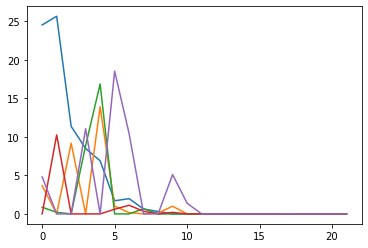

In [29]:
# let us use 5
model = NMF(n_components=k)
W = model.fit_transform(X)
H = model.components_
plt.plot(H[0])
plt.plot(H[1])
plt.plot(H[2])
plt.plot(H[3])
plt.plot(H[4])
print(np.round(W,2))